### Dataset Downloading

In [1]:
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/-4g-l44mqslQXg) -o data.zip
!unzip data.zip >> /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  194M  100  194M    0     0   9.8M      0  0:00:19  0:00:19 --:--:-- 14.1M
replace content/kaggle_dataset_3/train/malignant/malignant (127).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [2]:
!pip install -q segmentation-models-pytorch --no-cache-dir
!pip install albumentations
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ihw8vu2w
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ihw8vu2w
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-14-4b6a996d9396>:18: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
<ipython-input-14-4b6a996d9396>:20: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),


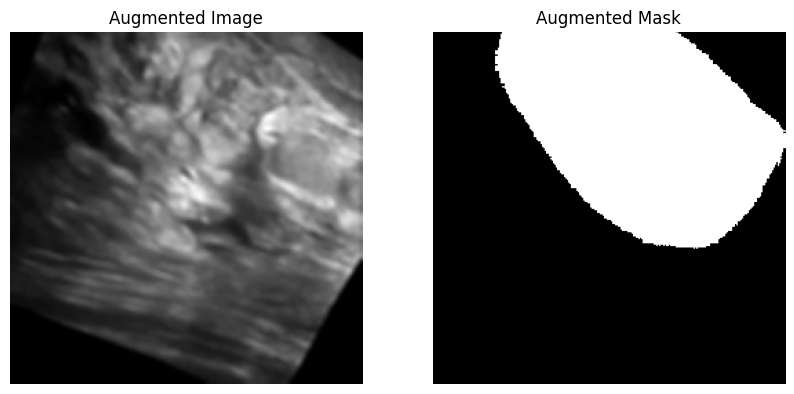

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

def get_augmentation_pipeline(image_size=(256, 256), augment=True):
    if augment:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.GaussianBlur(blur_limit=(5, 9), p=0.3),
            A.RandomGamma(gamma_limit=(70, 130), p=0.3),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
            A.Normalize(mean=[0.5], std=[0.5]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Normalize(mean=[0.5], std=[0.5]),
            ToTensorV2(),
        ])

class MultiClassBUSIDataset(Dataset):
    def __init__(self, root_dir, image_size=(256, 256), transform=None, samples=None,
                 include_normal=True, augment=False):
        self.root_dir = root_dir
        self.image_size = image_size
        self.transform = transform
        self.include_normal = include_normal
        self.augment = augment
        self.class_to_idx = {'background': 0, 'benign': 1, 'malignant': 2}
        if samples is not None:
            self.samples = samples
        else:
            self.samples = self._scan_dataset()
        self.augmentation_pipeline = get_augmentation_pipeline(image_size, augment=augment)

    def _scan_dataset(self):
        samples = []
        subfolders = ["benign", "malignant", "normal"] if self.include_normal else ["benign", "malignant"]
        for sf in subfolders:
            folder_path = os.path.join(self.root_dir, sf)
            mask_paths = glob.glob(os.path.join(folder_path, "*_mask.png"))
            for mp in mask_paths:
                img_path = mp.replace("_mask", "")
                if os.path.exists(img_path):
                    class_id = 0 if sf == "normal" else 1 if sf == "benign" else 2
                    samples.append((img_path, mp, class_id))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, class_id = self.samples[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        binary_mask = (mask > 127).astype(np.uint8)
        multi_class_mask = np.zeros_like(binary_mask) if class_id == 0 else binary_mask * class_id
        if self.augment and self.augmentation_pipeline is not None:
            augmented = self.augmentation_pipeline(image=image, mask=multi_class_mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image).unsqueeze(0).float() / 255.0
            mask = torch.from_numpy(multi_class_mask).long()
        return image, mask

def create_train_val_datasets(root_dir, val_ratio=0.2, image_size=(256, 256), include_normal=True, stratify=True, augment_train=True):
    import os
    import glob
    import random
    from collections import defaultdict
    subfolders = ["benign", "malignant", "normal"] if include_normal else ["benign", "malignant"]
    all_samples = []
    samples_by_class = defaultdict(list)
    for sf in subfolders:
        folder_path = os.path.join(root_dir, sf)
        mask_paths = glob.glob(os.path.join(folder_path, "*_mask.png"))
        for mp in mask_paths:
            img_path = mp.replace("_mask", "")
            if os.path.exists(img_path):
                class_id = 0 if sf == "normal" else 1 if sf == "benign" else 2
                sample = (img_path, mp, class_id)
                all_samples.append(sample)
                samples_by_class[class_id].append(sample)
    train_samples = []
    val_samples = []
    if stratify:
        for class_id, samples in samples_by_class.items():
            random.shuffle(samples)
            val_count = int(len(samples) * val_ratio)
            val_samples.extend(samples[:val_count])
            train_samples.extend(samples[val_count:])
    else:
        random.shuffle(all_samples)
        val_count = int(len(all_samples) * val_ratio)
        val_samples = all_samples[:val_count]
        train_samples = all_samples[val_count:]
    train_dataset = MultiClassBUSIDataset(root_dir, image_size=image_size, samples=train_samples, include_normal=include_normal, augment=augment_train)
    val_dataset = MultiClassBUSIDataset(root_dir, image_size=image_size, samples=val_samples, include_normal=include_normal, augment=False)
    return train_dataset, val_dataset

root_dir='/content/content/kaggle_dataset_3/train'
train_dataset, val_dataset = create_train_val_datasets(root_dir=root_dir, val_ratio=0.2, image_size=(256, 256), include_normal=True, stratify=True, augment_train=True)
image, mask = train_dataset[0]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Augmented Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Augmented Mask")
plt.axis('off')
plt.show()

In [19]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the enhanced U-Net model with a pre-trained encoder
def get_enhanced_unet(encoder_name='resnet50', encoder_weights='imagenet', in_channels=1, out_channels=3):
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=out_channels,
        decoder_attention_type='scse',
        activation='softmax2d',
    )
    return model

# Initialize the enhanced model
model = get_enhanced_unet(encoder_name='resnet50', encoder_weights='imagenet', in_channels=1, out_channels=3)
model = model.to(device)
print(model)

# Define the combined Dice and Focal Loss with class weights
class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, smooth=1e-6, class_weights=None):
        super(DiceFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        targets = targets.long()
        inputs_softmax = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (inputs_softmax * targets_one_hot).sum(dim=(2, 3))
        union = inputs_softmax.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice_loss = 1 - (2 * intersection + self.smooth) / (union + self.smooth)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.class_weights)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        loss = self.alpha * dice_loss.mean() + (1 - self.alpha) * focal_loss.mean()
        return loss

# Calculate class weights based on dataset
def calculate_class_weights(dataset):
    class_counts = torch.zeros(3)
    for _, mask in dataset:
        class_counts += torch.bincount(mask.flatten(), minlength=3)
    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights /= class_weights.sum()
    return class_weights.to(device)

# Initialize the loss function with class weights
class_weights = calculate_class_weights(train_dataset)
print(f"Class Weights: {class_weights}")
criterion = DiceFocalLoss(alpha=0.5, gamma=2.0, class_weights=class_weights)

# Define the Dice score calculation for a specific class
def calculate_dice_score_for_class(preds, targets, class_id, smooth=1e-6):
    pred_class = (preds == class_id).float()
    target_class = (targets == class_id).float()
    intersection = (pred_class * target_class).sum(dim=(1, 2))
    union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

# Define the Dice score calculation for overall segmentation
def calculate_dice_score(preds, targets, smooth=1e-6):
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1, 2))
    union = preds.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

# Define the training loop with learning rate warm-up and gradient clipping
def train_enhanced_unet(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, device=None):
    import wandb
    wandb.init(project="busi-multiclass-segmentation", config={
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": learning_rate,
        "architecture": "Enhanced U-Net (ResNet50)",
        "optimizer": "AdamW"
    })
model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    writer = SummaryWriter(log_dir=f'runs/unet_{time.strftime("%Y%m%d_%H%M%S")}')
    best_val_loss = float('inf')
    early_stopping_patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            writer.add_scalar('Train/Batch Loss', loss.item(), epoch * len(train_loader) + batch_idx)
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_dice_bg = 0.0
        val_dice_benign = 0.0
        val_dice_malignant = 0.0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                preds = torch.argmax(output, dim=1)
                dice_bg = calculate_dice_score_for_class(preds, target, class_id=0)
                dice_benign = calculate_dice_score_for_class(preds, target, class_id=1)
                dice_malignant = calculate_dice_score_for_class(preds, target, class_id=2)
                val_dice_bg += dice_bg
                val_dice_benign += dice_benign
                val_dice_malignant += dice_malignant
                dice_score = calculate_dice_score(preds, target)
                val_dice += dice_score

        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_dice_bg /= len(val_loader)
        val_dice_benign /= len(val_loader)
        val_dice_malignant /= len(val_loader)

        writer.add_scalar('Train/Epoch Loss', train_loss, epoch)
        writer.add_scalar('Validation/Epoch Loss', val_loss, epoch)
        writer.add_scalar('Validation/Dice Score', val_dice, epoch)
        writer.add_scalar('Validation/Dice Background', val_dice_bg, epoch)
        writer.add_scalar('Validation/Dice Benign', val_dice_benign, epoch)
        writer.add_scalar('Validation/Dice Malignant', val_dice_malignant, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Validation Dice Scores:")
        print(f"  - Background: {val_dice_bg:.5f}")
        print(f"  - Benign: {val_dice_benign:.5f}")
        print(f"  - Malignant: {val_dice_malignant:.5f}")
        print(f"  - Overall: {val_dice:.5f}")
        wandb.log({
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Val Loss": val_loss,
            "Val Dice Overall": val_dice,
            "Val Dice Background": val_dice_bg,
            "Val Dice Benign": val_dice_benign,
            "Val Dice Malignant": val_dice_malignant
        })

    writer.close()
    return model

# Define the evaluation function with additional metrics
def evaluate_model(model, val_loader, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_precision = 0.0
    val_recall = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            dice_score = calculate_dice_score(preds, target)
            val_dice += dice_score

            # Calculate IoU, Precision, and Recall
            iou, precision, recall = calculate_metrics(preds, target)
            val_iou += iou
            val_precision += precision
            val_recall += recall

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")
    print(f"Validation IoU: {val_iou:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

# Define the function to calculate IoU, Precision, and Recall
def calculate_metrics(preds, targets, num_classes=3, smooth=1e-6):
    iou = 0.0
    precision = 0.0
    recall = 0.0

    for class_id in range(num_classes):
        pred_class = (preds == class_id).float()
        target_class = (targets == class_id).float()
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum() - intersection
        iou += (intersection + smooth) / (union + smooth)
        precision += (intersection + smooth) / (pred_class.sum() + smooth)
        recall += (intersection + smooth) / (target_class.sum() + smooth)

    iou /= num_classes
    precision /= num_classes
    recall /= num_classes

    return iou, precision, recall

# Create train and validation datasets
train_dataset, val_dataset = create_train_val_datasets(
    root_dir='/content/content/kaggle_dataset_3/train',
    val_ratio=0.2,
    image_size=(256, 256),
    include_normal=True,
    stratify=True,
    augment_train=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Fix multiprocessing issue in Jupyter
if __name__ == "__main__":
    train_enhanced_unet(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=50, learning_rate=1e-4, device=device)
    evaluate_model(model, val_loader, device=device)

Using device: cuda
Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-14-4b6a996d9396>:18: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
<ipython-input-14-4b6a996d9396>:20: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),


Epoch 1/50, Train Loss: 0.4069, Val Loss: 0.4059
Validation Dice Scores:
  - Background: 0.37325
  - Benign: 0.06268
  - Malignant: 0.02302
  - Overall: 0.18404
Epoch 2/50, Train Loss: 0.4055, Val Loss: 0.4042
Validation Dice Scores:
  - Background: 0.47414
  - Benign: 0.06403
  - Malignant: 0.02207
  - Overall: 0.18363
Epoch 3/50, Train Loss: 0.4028, Val Loss: 0.4000
Validation Dice Scores:
  - Background: 0.64344
  - Benign: 0.07890
  - Malignant: 0.03441
  - Overall: 0.21430
Epoch 4/50, Train Loss: 0.3993, Val Loss: 0.3958
Validation Dice Scores:
  - Background: 0.76261
  - Benign: 0.10454
  - Malignant: 0.04772
  - Overall: 0.27235
Epoch 5/50, Train Loss: 0.3947, Val Loss: 0.3880
Validation Dice Scores:
  - Background: 0.85068
  - Benign: 0.15529
  - Malignant: 0.08236
  - Overall: 0.36536
Epoch 6/50, Train Loss: 0.3897, Val Loss: 0.3820
Validation Dice Scores:
  - Background: 0.85335
  - Benign: 0.18421
  - Malignant: 0.10087
  - Overall: 0.38718
Epoch 7/50, Train Loss: 0.3848, Va

Validation Loss: 0.3651, Validation Dice: 0.5589


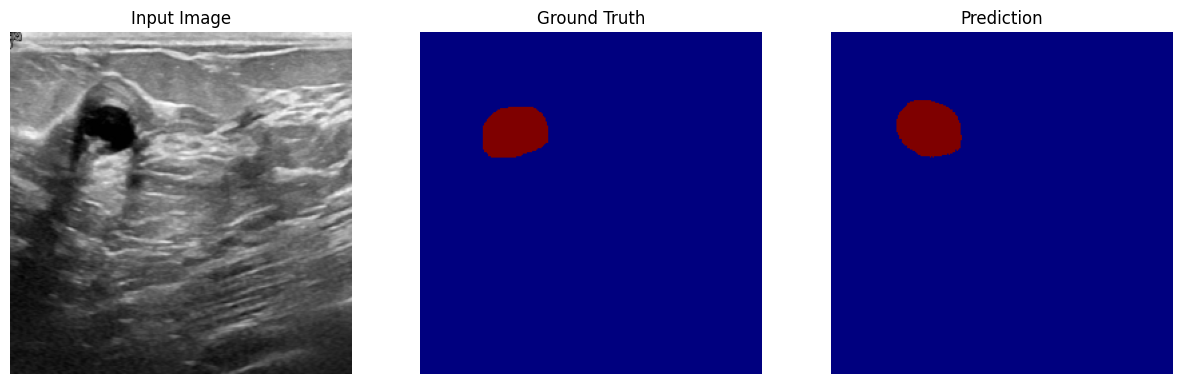

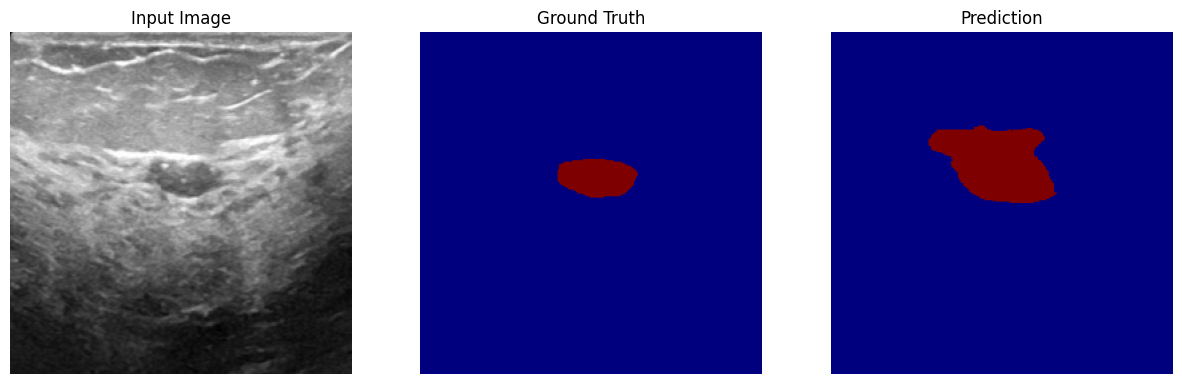

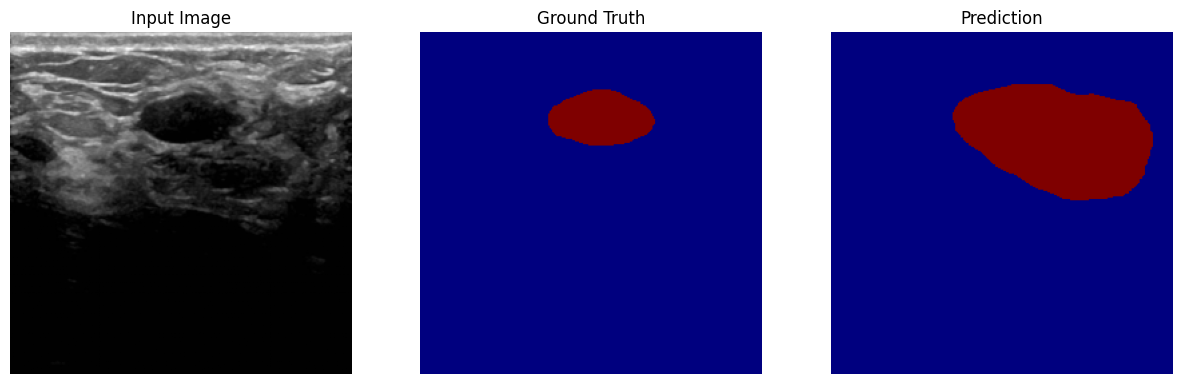

In [20]:
# Evaluate the model
def evaluate_model(model, val_loader, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            dice_score = calculate_dice_score(preds, target)
            val_dice += dice_score
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")

evaluate_model(model, val_loader, device=device)

# Visualize predictions
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            if i >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = torch.argmax(output, dim=1)
            image = data[0].cpu().squeeze().numpy()
            target_mask = target[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(target_mask, cmap='jet')
            plt.title("Ground Truth")
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='jet')
            plt.title("Prediction")
            plt.axis('off')
            plt.show()

visualize_predictions(model, val_loader, device=device, num_samples=3)

In [21]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Define the test dataset class
class BUSITestDataset(Dataset):
    def __init__(self, test_dir, image_size=(256, 256)):
        self.test_dir = test_dir
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.test_dir, image_name)
        image_id = os.path.splitext(image_name)[0]
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        original_size = original_image.shape
        image = cv2.resize(original_image, self.image_size, interpolation=cv2.INTER_AREA)
        image = image.astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image).unsqueeze(0)
        return {
            'image': image_tensor,
            'image_id': image_id,
            'original_h': original_size[0],
            'original_w': original_size[1]
        }

def rle_encode_mask(mask):
    if np.sum(mask) == 0:
        return ''
    pixels = mask.flatten()
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs = np.concatenate([[0], runs])
    run_lengths = []
    for i in range(len(runs) - 1):
        if pixels[runs[i]] == 1:
            start = runs[i] + 1
            length = runs[i + 1] - runs[i]
            run_lengths.extend([start, length])
    return ' '.join(str(x) for x in run_lengths)

def combined_encode(masks_dict, delimiter="~"):
    if not masks_dict:
        return ""
    encoded_parts = []
    for class_id, mask in masks_dict.items():
        rle = rle_encode_mask(mask)
        if rle:
            encoded_parts.append(f"{class_id}:{rle}")
    return delimiter.join(encoded_parts)

def generate_submission(model, test_dir, output_file, batch_size=4, device=None, image_size=(256, 256)):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_dataset = BUSITestDataset(test_dir, image_size=image_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    model.to(device)
    model.eval()
    results = {'ID': [], 'encoded_pixels': []}
    print("Generating predictions...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            image_ids = batch['image_id']
            original_hs = batch['original_h']
            original_ws = batch['original_w']
            outputs = model(images)
            batch_size = images.shape[0]
            is_multiclass = outputs.shape[1] > 1
            if is_multiclass:
                predictions = torch.argmax(outputs, dim=1).cpu().numpy()
                for i in range(batch_size):
                    image_id = image_ids[i]
                    pred = predictions[i]
                    orig_h, orig_w = original_hs[i].item(), original_ws[i].item()
                    pred_resized = cv2.resize(pred.astype(np.float32), (orig_w, orig_h), interpolation=cv2.INTER_NEAREST).astype(np.int32)
                    masks_dict = {}
                    for class_id in range(1, outputs.shape[1]):
                        binary_mask = (pred_resized == class_id).astype(np.uint8)
                        if np.sum(binary_mask) > 0:
                            masks_dict[class_id] = binary_mask
                    encoded_pixels = combined_encode(masks_dict)
                    results['ID'].append(image_id)
                    results['encoded_pixels'].append(encoded_pixels)
    submission_df = pd.DataFrame(results)
    submission_df['encoded_pixels'] = submission_df['encoded_pixels'].fillna('')
    submission_df.loc[submission_df['encoded_pixels'] == '', 'encoded_pixels'] = '<empty>'
    submission_df = submission_df.sort_values('ID')
    submission_df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    print(f"Total entries: {len(submission_df)}")
    print(f"Empty predictions: {(submission_df['encoded_pixels'] == '<empty>').sum()}")
    return submission_df

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model with correct encoder
model = get_enhanced_unet(encoder_name='resnet50', encoder_weights=None, in_channels=1, out_channels=3)

# Load trained model weights (strict=False to handle key mismatches)
model.load_state_dict(torch.load('best_model.pth', map_location=device), strict=False)

# Move model to device
model = model.to(device)
model.eval()

# Generate submission
generate_submission(
    model=model,
    test_dir='/content/content/kaggle_dataset_3/test',
    output_file='submission.csv',
    batch_size=16,
    device=device
)

Generating predictions...


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

Submission saved to submission.csv
Total entries: 156
Empty predictions: 17


,ID,encoded_pixels
0,image_000,1:98131 3 98809 3 99487 3 100165 8 100843 8 10...
1,image_001,1:14854 39 15409 39 15895 17 15914 3 15921 6 1...
2,image_002,<empty>
3,image_003,1:46999 35 47688 35 48369 51 49058 51 49747 51...
4,image_004,1:151467 3 152239 3 153005 18 153777 18 154549...
...,...,...
151,image_151,1:94983 35 95739 35 96489 47 97245 47 97995 62...
152,image_152,1:34822 12 35174 24 35531 24 35883 32 36237 36...
153,image_153,1:145439 24 146202 24 146965 24 147719 51 1484...
154,image_154,2:148380 21 149163 21 149943 31 150726 31 1514...
